# Chapter 5. 오차역전파법

앞 장에서는 신경망 학습에 대한 설명이었다. 그때 신경망의 가중치 매개변수의 기울기(정확히는 가중치 매개변수에 대한 손실 함수의 기울기)는 수치 미분을 사용해 구했는데, 수치 미분은 단순하고 구현하기 쉽지만, 계산 시간이 오래 걸린다는 단점이 있다.

이번 장에서 가중치 매개변수의 기울기를 효율적으로 계산하는 '오차역전파법(backpropagation)'을 알아보자.
- 수식
- 계산 그래프

를 통해 오차역전파법을 이해할 수 있는데, '시각적'으로 계산 그래프를 사용해서 이해해 보자. (cs231n 참조)

## 5.1 계산 그래프(computational graph)
계산 과정을 그래프로 나타낸 것으로, 복수의 **노드(node)**와 **에지(edge)**로 표현된다. (노드 사이의 직선을 '에지'라고 함)


### 5.1.1 계산 그래프로 풀다

```
문제 1: 현빈 군은 슈퍼에서 1개에 100원인 사과를 2개 샀습니다. 이때 지불 금액을 구하세요. 단, 소비세가 10% 부과됩니다.
```


이때, 표기법은 다음과 같다.
- 계산 과정 => 노드(○), 화살표(왼->오)

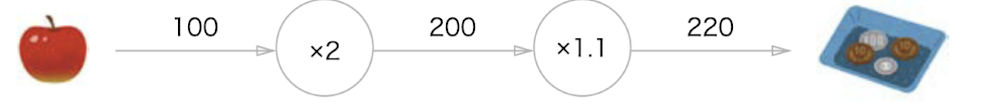

위 이미지에서 'x 2', 'x 1.1'을 각각 하나의 연산으로 취급했지만, 곱셈인 'x'만을 연산으로 생각한다면 '2', '1.1'은 각 '사과의 개수', '소비세' 변수가 되어 원 밖에 표시할 수도 있다.

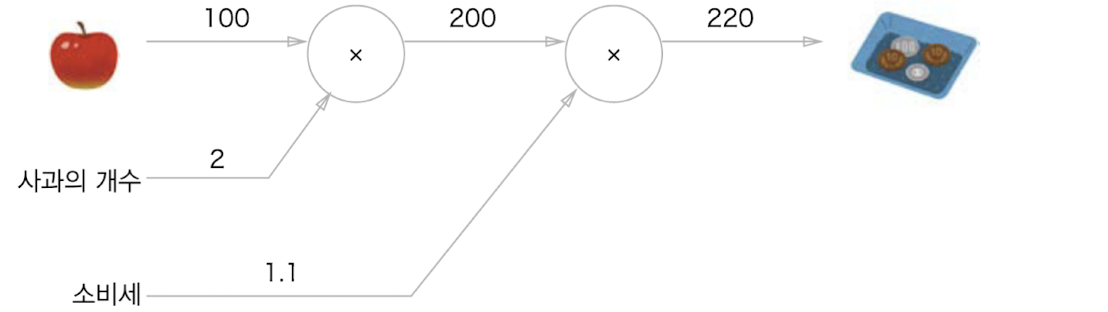

다음 문제로,


```
문제 2: 현빈 군은 슈퍼에서 사과를 2개, 귤을 3개 샀습니다. 사과는 1개에 100원, 귤을 1개에 150원입니다. 소비세가 10%일 때 지불 금액을 구하세요.
```



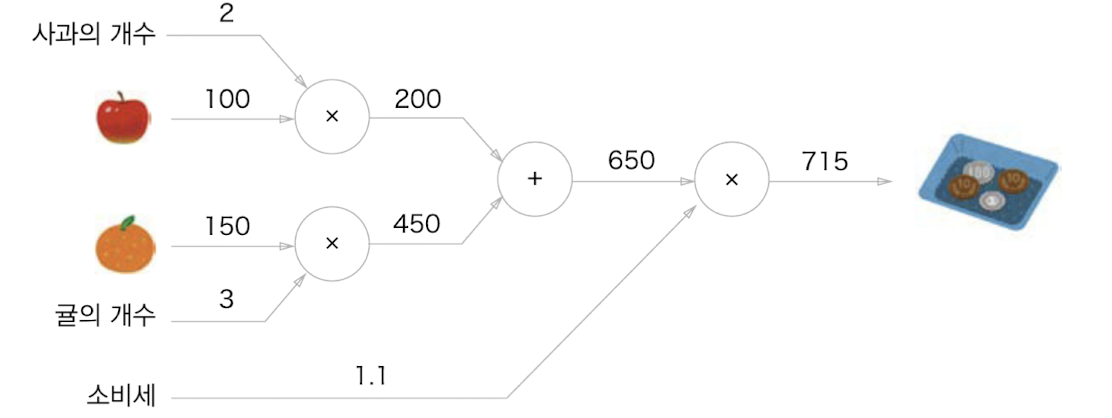

여기서는 덧셈 노드인 '+'가 새로 등장하여 사과와 귤을 금액을 합산한다.

정리하자면, 계산 그래프를 이용한 문제 풀이는 다음과 같이 진행한다.
1. 계산 그래프를 구성한다.
2. 그래프에서 계산을 왼쪽에서 오른쪽으로 진행한다.

여기서 2번을 순전파(forward propagation)라 하고, 반대 방향(오->왼)의 전파를 역전파(backward propagation)라 한다.

### 5.1.2 국소적 계산

계산 그래프의 특징은 '국소적 계산(자신과 직접 관계된 작은 범위)'을 전파함으로써 최종 결과를 얻는다는 점에 있다.

예를 들어, 슈퍼마켓에서 사과 2개를 포함한 여러 식품을 구입하는 경우, 각 노드에서의 계산은 국소적 계산이다.
- 사과와 그외의 물품 값을 더하는 계산은 숫자가 어떻게 계산되었느냐에 상관없이, 단지 두 숫자를 더하면 됨
- 각 노드는 자신과 관련된 계산(덧셈) 외에는 신경 안 써도 됨

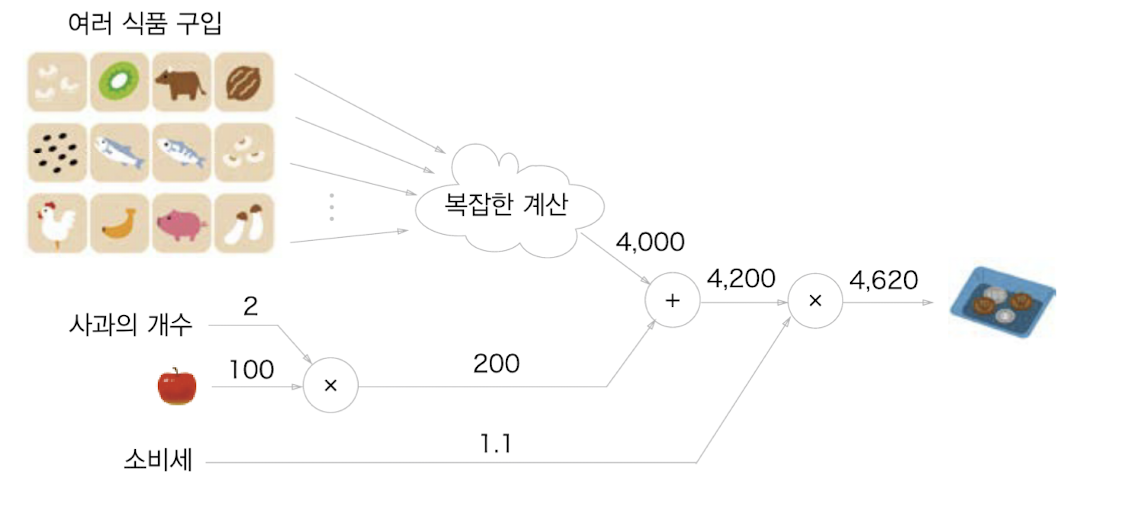

### 5.1.3 왜 계산 그래프로 푸는가?

결론적으로, 계산 그래프의 이점 중 하나는 '국소적 계산'이다. 전체가 아무리 복잡해도 각 노드에서는 단순한 계산에 집중하여 문제를 단순화할 수 있다.

또 다른 이점으로, 계산 그래프는 중간 계산 결과를 모두 보관할 수 있다.

이러한 이점들이 있지만, 실제 계산 그래프를 사용하는 가장 큰 이유는 역전파를 통해 '미분'을 효율적으로 계산할 수 있다는 점이다.
- ex. 문제 1에서 가령 사과 가격이 오르면 최종 금액에 어떤 영향을 끼치는지 알고 싶다. -> '사과 가격에 대한 지불 금액의 미분'을 알고 싶다는 것과 같음.
- 사과 값을 x, 지불 금액을 L이라 했을 때, $\frac{dL}{dx}$을 구하는 것. (사과 값이 '아주 조금' 올랐을 때 지불 금액에 얼마나 증가할지)


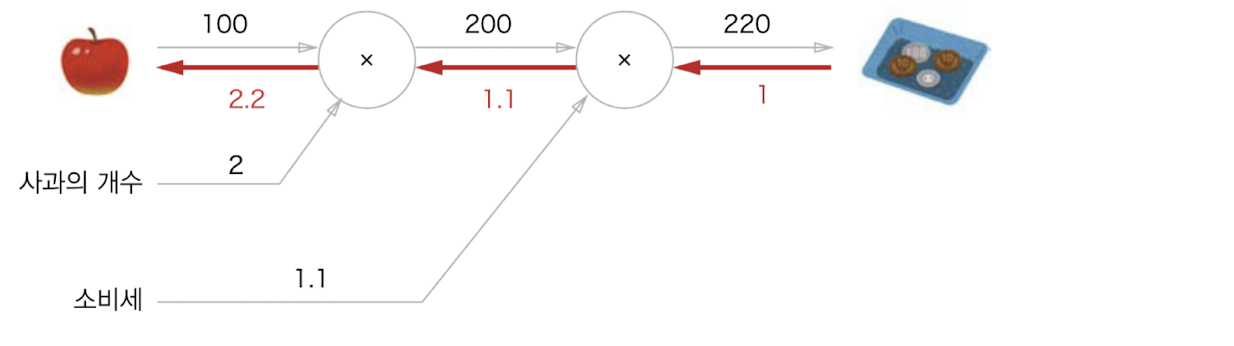

- 전파는 '국소적 미분'을 전달하고 그 미분 값은 화살표 아래에 적음
- 즉, 위 이미지의 역전파는 '1->1.1->2.2' 순으로 미분 값을 전달한다. 사과가 1원 오르면 최종 금액은 2.2원 오른다는 뜻. (사과 값이 아주 조금 오르면 최종 금액은 그 아주 작은 값의 2.2배만큼 오름)

따라서 계산 그래프의 이점은 순전파와 역전파를 활용하여 각 변수의 미분을 효율적으로 구할 수 있다는 것이다.

## 5.2 연쇄법칙

추가적으로, 위와 같이 '국소적 미분'을 순전파, 역전파로 전달하는 원리는 **연쇄법칙(chain rule)**에 따른 것이다.

### 5.2.1 계산 그래프의 역전파

계산 그래프를 사용한 역전파의 예, $y=f(x)$를 살펴보자.
- 국소적 미분: 순전파 때의 $y=f(x)$ 계산의 미분을 구하는 것.
- 즉, $x$에 대한 $y$의 미분 $\frac{dy}{dx}$ 을 구한다는 뜻이다.
- 그리고 구한 (국소적인) 미분을 상류에서 전달된 값(이 예에서는 $E$)에 곱해 앞쪽 노드로 전달하는 것.

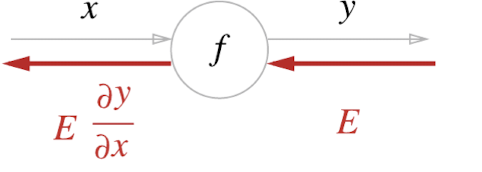

### 5.2.2 연쇄법칙이란?

연쇄법칙을 설명하기 전 합성 함수에 대해 알아보자. 합성 함수란 여러 함수로 구성된 함수로, 예를 들어 $z=(x+y)^2$이라는 식은 아래와 같이 두 개의 식으로 구성된다.
- $z=t^2$
- $t=x+y$

연쇄법칙은 합성 함수의 미분에 대한 성질이며, 다음과 같이 정의된다.


```
합성 함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타낼 수 있다.
```

1. ($x$에 대한 $z$의 미분)은 ($t$에 대한 $z$의 미분)과 ($x$에 대한 $t$의 미분)의 곱으로 나타낼 수 있다.  
$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial t} \cdot \frac{\partial t}{\partial x}$

2. 공통된 부분을 지우고, 연쇄법칙으로 위의 식의 국소적 미분(편미분)을 구한다.

3. 최종적으로 구하고 싶은 $x$에 대한 $z$의 미분은 두 미분을 곱하여 계산한다.
$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial t} \cdot \frac{\partial t}{\partial x} = 2t \cdot 1 = 2(x + y)$


### 5.2.3 연쇄법칙과 계산 그래프

위 식의 연쇄법칙 계산을 계산 그래프로 나타내자.

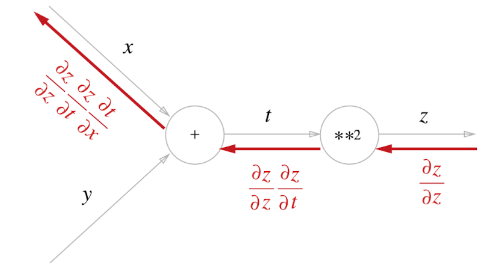

위에서 주목할 점은 맨 왼쪽의 역전파이다. 이 계산은 연쇄법칙에 따르면 다음과 같이 성립되어 '$x$에 대한 $z$의 미분'이 된다.

$\frac{\partial z}{\partial z} \frac{\partial z}{\partial t} \frac{\partial t}{\partial x} = \frac{\partial z}{\partial t} \frac{\partial t}{\partial x} = \frac{\partial z}{\partial x} $

즉, 역전파가 하는 일은 연쇄법칙의 원리와 같다는 것이다.

위 그림에 국소적 미분(2t, 1)을 대입하면 다음과 같이 결과는 $2(x+y)$임을 구할 수 있다.

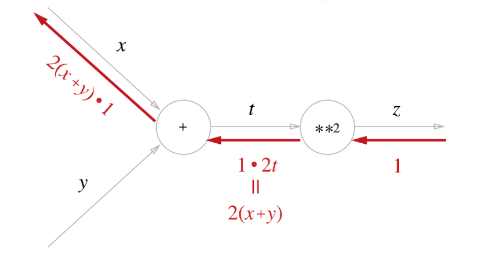

## 5.3 역전파
이번 절에서는 '+'와 'x' 등의 연산을 예로 들어 역전파의 구조를 설명한다.

### 5.3.1 덧셈 노드의 역전파

$z=x+y$라는 식을 대상으로 역전파를 살펴보자.

$\frac{\partial z}{\partial x} = 1$, $\frac{\partial z}{\partial y} = 1$


- 왼쪽이 순전파, 오른쪽이 역전파.

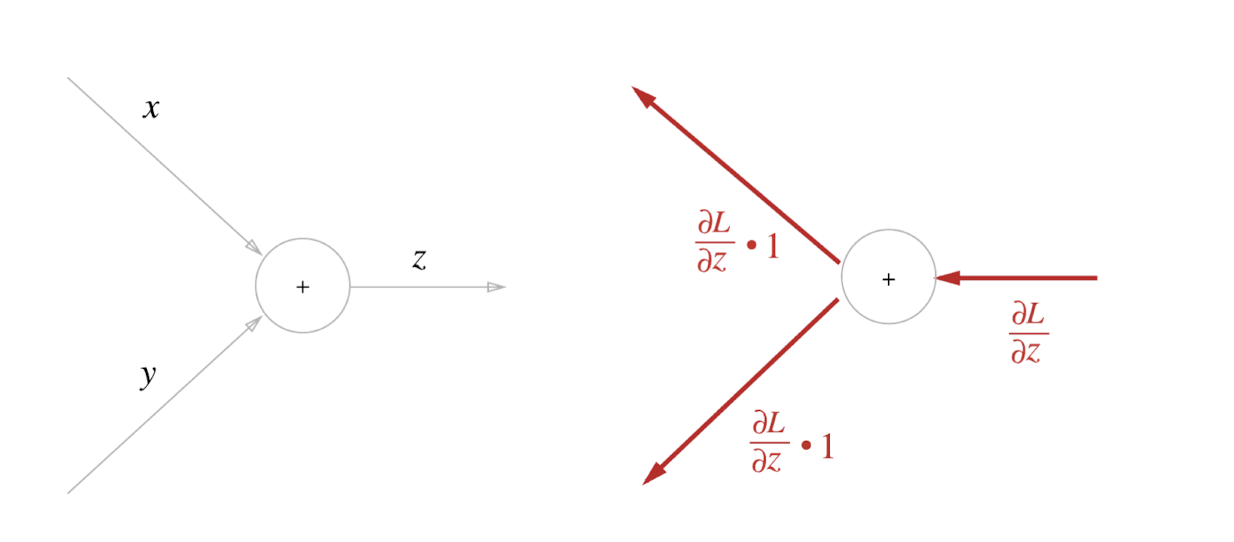

위와 같이 역전파 때는 상류에서 전해진 미분(이 예에서는 $\frac{\partial L}{\partial z}$)에 1을 곱하여 하류로 흘림. 즉, 1을 곱하기만 할 뿐이므로 입력된 값을 그대로 다음 노드로 보냄.

상류에서 전해진 미분 값을 $\frac{\partial L}{\partial z}$이라 한 이유는, 최종적으로 $L$이라는 값을 출력하는 큰 계산 그래프를 가정하기 때문이다.

결론적으로 덧셈 노드 역전파는 입력 신호를 다음 노드로 출력할 뿐이므로, 그대로 다음 노드로 전달한다.

### 5.3.2 곱셈 노드의 역전파

이어서 곱셈 노드의 역전파를 설명하는 예로 $z=xy$를 살펴보자.

$\frac{\partial z}{\partial x} = y$, $\frac{\partial z}{\partial y} = x$


- 왼쪽이 순전파, 오른쪽이 역전파.

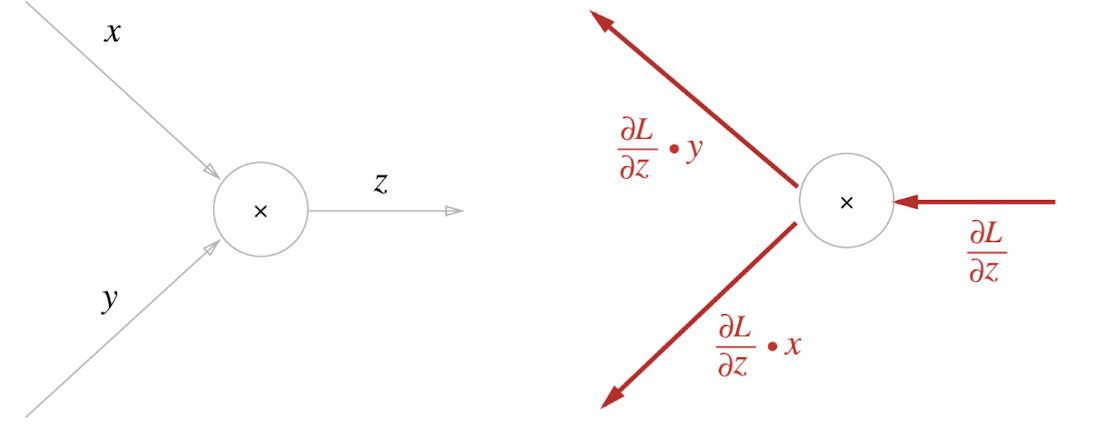

곱셈 노드 역전파는 상류의 값에 순전파 때의 입력 신호들을 '서로 바꾼 값'을 곱해서 하류로 보낸다. (덧셈에서와 다른 점)

따라서 곱셈 노드를 구현할 때는 순전파의 입력 신호를 변수에 저장해둔다.

### 5.3.3 사과 쇼핑의 예

이 문제에서는 3가지 변수 각각이 최종 금액에 어떻게 영향을 주느냐를 풀고자 한다. 즉, 각각에 대한 지불 금액의 미분을 구하는 것이다.
- 사과의 가격
- 사과의 개수
- 소비세

이를 계산 그래프의 역전파를 사용해서 풀면 다음과 같다.

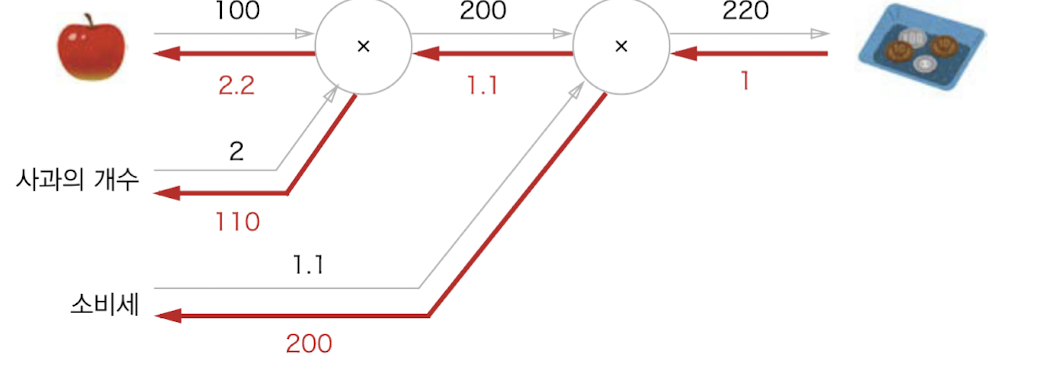

결과를 보면 다음과 같다.
- 사과 가격의 미분: 2.2
- 사과 개수의 미분: 110
- 소비세의 미분: 200

이는 소비세와 사과 가격이 같은 양만큼 오르면 최종 금액에는 소비세가 200의 크기로, 사과 가격이 2.2 크기로 영향을 준다고 해석할 수 있다. 단, 이 예에서 소비세과 사과 가격은 단위가 다르니 주의해야 한다. (소비세 1은 100%, 사과 가격 1은 1원)


*=> 예시가 헷갈림*

## 5.4 단순한 계층 구현하기

이번에는 '사과 쇼핑' 예를 파이썬으로 구현한다.

### 5.4.1 곱셈 계층

모든 계층은 forward()와 backward()라는 공통의 메서드(인터페이스)를 갖도록 구현한다.

In [1]:
class MulLayer:
  def __init__(self):
    self.x = None
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x * y

    return out

  def backward(self, dout): # dout는 상류에서 넘어온 미분
    dx = dout * self.y # x와 y를 바꾼다.
    dy = dout * self.x

    return dx, dy

그럼 위 'MulLayer'를 사용해서 앞에서 본 '사과 쇼핑'을 구현해 보자.
- 사과 2개 구입

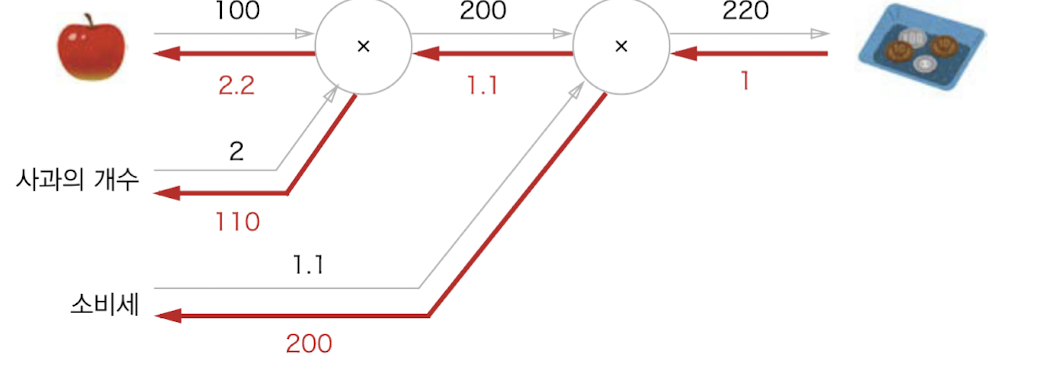

In [3]:
apple = 100
apple_num = 2
tax = 1.1

# 계층들
mul_apple_Layer = MulLayer()
mul_tax_Layer = MulLayer()

# 순전파
apple_price = mul_apple_Layer.forward(apple, apple_num)
price = mul_tax_Layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [4]:
# 역전파
dprice = 1
dapple_price, dtax = mul_tax_Layer.backward(dprice)
dapple, dapple_num = mul_apple_Layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


- backward() 호출 순서는 forward() 때와는 반대
- backward()가 받는 인수는 '순전파의 출력에 대한 미분'
- mul_apple_layer라는 곱셈 계층은 순전파 때는 apple_price를 출력하지만, 역전파 때는 apple_price의 미분 값인 dapple_price를 인수로 받음

### 5.4.2 덧셈 계층

In [6]:
class AddLayer:
  def __init__(self): # 덧셈 계층에는 초기화 필요없음 -> ?
    pass

  def forward(self, x, y):
    out = x + y
    return out

  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    return dx, dy

이상의 덧셈 계층과 곱셈 계층을 사용하여 사과 2개와 귤 3개를 사는 상황을 구현해 보자.

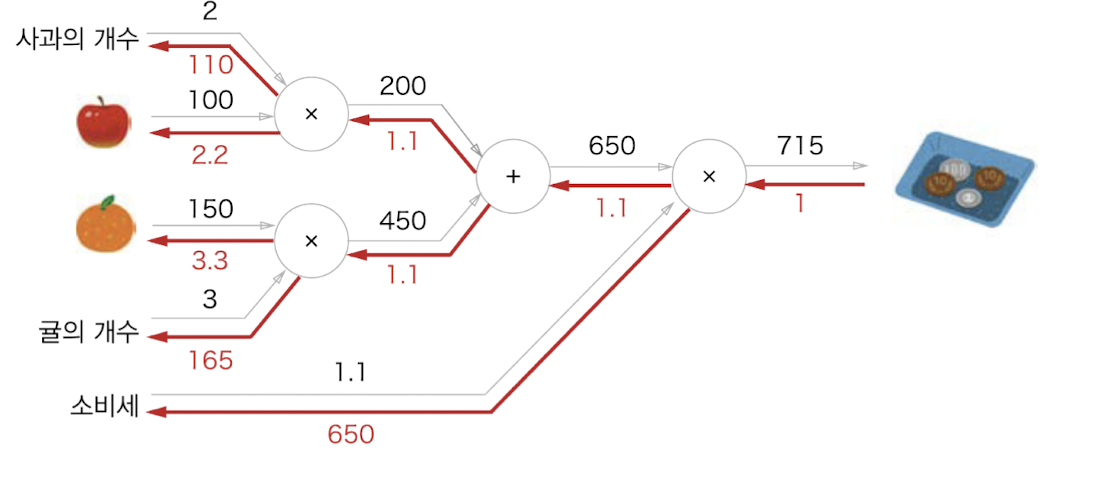

In [7]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# 역전파
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


## 5.5 활성화 함수 계층 구현하기

계산 그래프를 신경망에 적용해 보자. 여기에서는 신경망을 구성하는 층(계층) 각각을 클래스 하나로 구현한다. 우선은 활성화 함수인 ReLU와 Sigmoid 계층을 구현하도록 한다.

### 5.5.1 ReLU 계층

활성화 함수로 사용되는 ReLU의 수식은 다음과 같다.

$
y =
\begin{cases}
x & (x > 0) \\
0 & (x \leq 0)
\end{cases}
$

여기서, $x$에 대한 $y$의 미분은 다음과 같다.

$
\frac{\partial y}{\partial x} =
\begin{cases}
1 & (x > 0) \\
0 & (x \leq 0)
\end{cases}
$

위와 같이 순전파 때의 입력인 $x$가 0보다 크면 역전파는 상류의 값을 그대로 하류로 흘린다. 반면, 순전파 때 $x$가 0 이하면 역전파 때는 하류로 신호를 보내지 않는다.(0을 보냄)

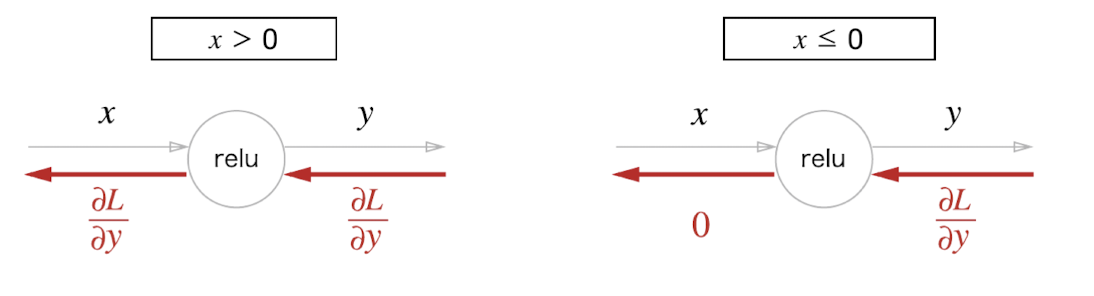

In [8]:
class Relu:
  def __init__(self):
    self.mask = None # mask는 True/False로 구성된 넘파이 배열

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout): # mask 원소가 True인 곳에는 상류에서 전파된 dout를 0으로 설정.
    dout[self.mask] = 0
    dx = dout

    return dx

In [9]:
import numpy as np
x = np.array( [[1.0, -0.5], [-2.0, 3.0]] )
print(x)

mask = (x <= 0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


### 5.5.2 Sigmoid 계층

시그모이드 함수의 수식은 다음과 같다.

$y = \frac{1}{1 + exp^{-x}}$

이를 계산 그래프로 그리면 다음과 같다. (순전파)

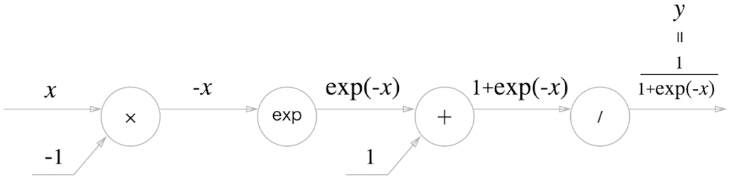

위 그림에서는 'exp'노드는 $y=exp(x)$ 계산을 수행하고, '/'노드는 $y=\frac{1}{x}$ 계산을 수행한다.

위 수식의 계산은 국소적 계산의 전파로 이루어지며, 이제 역전파에 대해 알아보도록 한다. 여기에서는 역전파의 흐름을 오른쪽에서 왼쪽으로 한 단계씩 짚어본다.

<1단계>

- '/' 노드, 즉,  $y=\frac{1}{x}$을 미분하면 다음의 식이 된다.
  $\frac{\partial y}{\partial x} = -\frac{1}{x^2} = -y^2$
- 역전파 때는 상류에서 흘러온 값에 $-y^2$(순전파의 출력을 제곱한 후 마이너스를 붙인 값)을 곱해서 하류로 전달함.



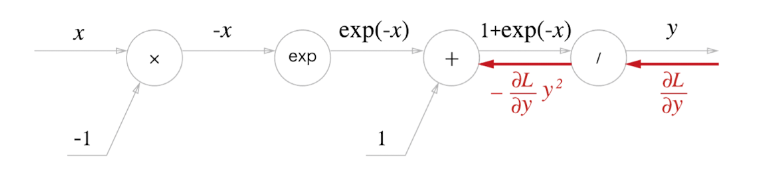

<2단계>

- '+'노드는 상류의 값을 여과 없이 하류로 내보낸다.



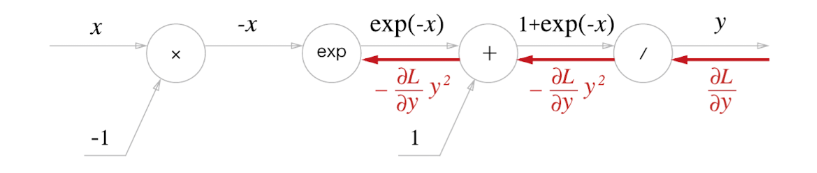

<3단계>
- 'exp'노드는 $y=exp(x)$ 연산을 수행하며, 그 미분은 다음과 같다.
  $\frac{\partial y}{\partial x} = exp(x)$
- 계산 그래프에서는 상류의 값에 순전파 때의 출력(이 예에서는 $exp(-x)$)을 곱해 하류로 전파함.

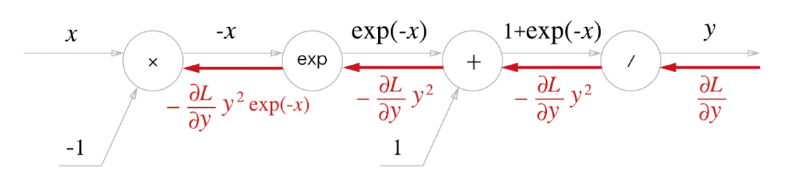

<4단계>

- 'x'노드는 순전파 때의 값을 '서로 바꿔' 곱한다. 이 예에서는 -1을 곱한다.

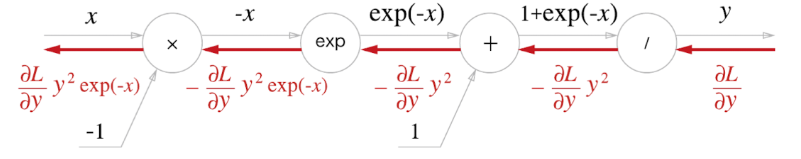

이렇게 Sigmoid 계층의 역전파를 계산 그래프로 완성된 것을 볼 수 있는데, 역전파의 최종 출력인 $\frac{\partial L}{\partial y} y^2 \exp(-x)$ 값이 하류 노드로 전파된다. 이는 온전히 순전파의 입력 $x$와 출력 $y$만으로 계산할 수 있었다.

위 계산 그래프의 중간 과정을 모두 묶어 다음과 같이 단순한 'sigmoid' 노드 하나로 대체할 수 있다.

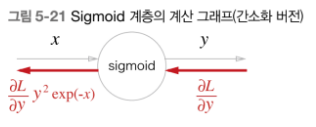

또한, $\frac{\partial L}{\partial y} y^2 \exp(-x)$는 다음처럼 정리해서 쓸 수 있다.

$\frac{\partial L}{\partial y} y^2 \exp(-x) = \frac{\partial L}{\partial y} \frac{1}{(1 + \exp(-x))^2} \exp(-x)
= \frac{\partial L}{\partial y} \frac{1}{1 + \exp(-x)} \frac{\exp(-x)}{1 + \exp(-x)}
= \frac{\partial L}{\partial y} y(1 - y)
$


이처럼 Sigmoid 계층의 역전파는 순전파의 출력(y)만으로 계산할 수 있다.

그리고 다음의 구현을 보면, 순전파의 출력을 인스턴스 변수 out에 보관했다가, 역전파 계산 때 그 값을 사용한다.

In [ ]:
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out

    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out

    return dx

## 5.6 Affine/Softmax 계층 구현하기

### 5.6.1 Affine 계층

신경망의 순전파에서는 가중치 신호의 총합을 계산하기 때문에 행렬의 곱(넘파이에서는 np.dot())을 사용했다. X, W, B는 각 형상이 (2,), (2,3), (3,)인 다차원 배열이므로, 뉴런의 가중치 합은 Y=np.dot(X,W)+B처럼 계산한다. 그리고 이 Y를 활성화 함수로 변환해 다음 층으로 전파하는 것이 신경망 순전파의 흐름이다.

행렬의 곱 계산은 대응하는 차원의 원소 수를 일치시키는 것이 핵심이다. 신경망의 순전파 때 수행하는 행렬의 곱은 기하학에서는 어파인 변환(affine transformation)이라 하므로, 이 책에서는 어파인 변환을 수행하는 처리를 'Affine 계층'이라는 이름으로 구현한다.

그럼, 앞에서 수행한 계산(행렬의 곱과 편향의 합)을 계산 그래프로 그려보면 다음과 같다.

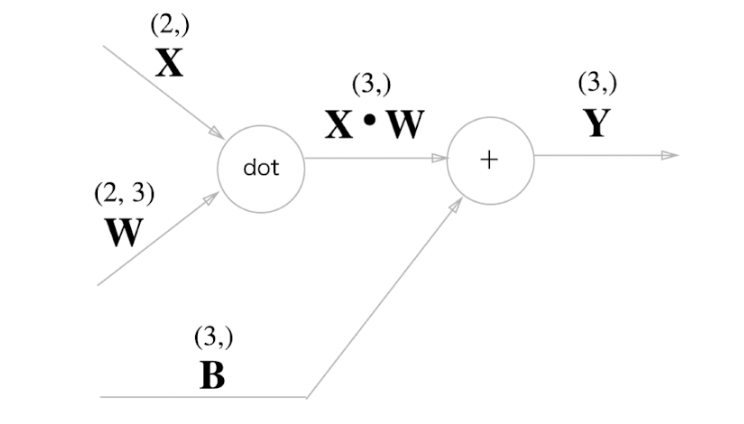

위를 보면 X, W, B가 행렬(다차원 배열)이라는 점에 주의해야 한다. 지금까지의 계산 그래프는 노드 사이에 '스칼라값'이 흘렀는 데 반해, 이 예에서는 '행렬'이 흐르고 있는 것이다.

이제 역전파에 대해 알아보자. (행렬을 사용한 역전파도 스칼라값을 사용한 지금까지의 계산 그래프와 같은 순서임)

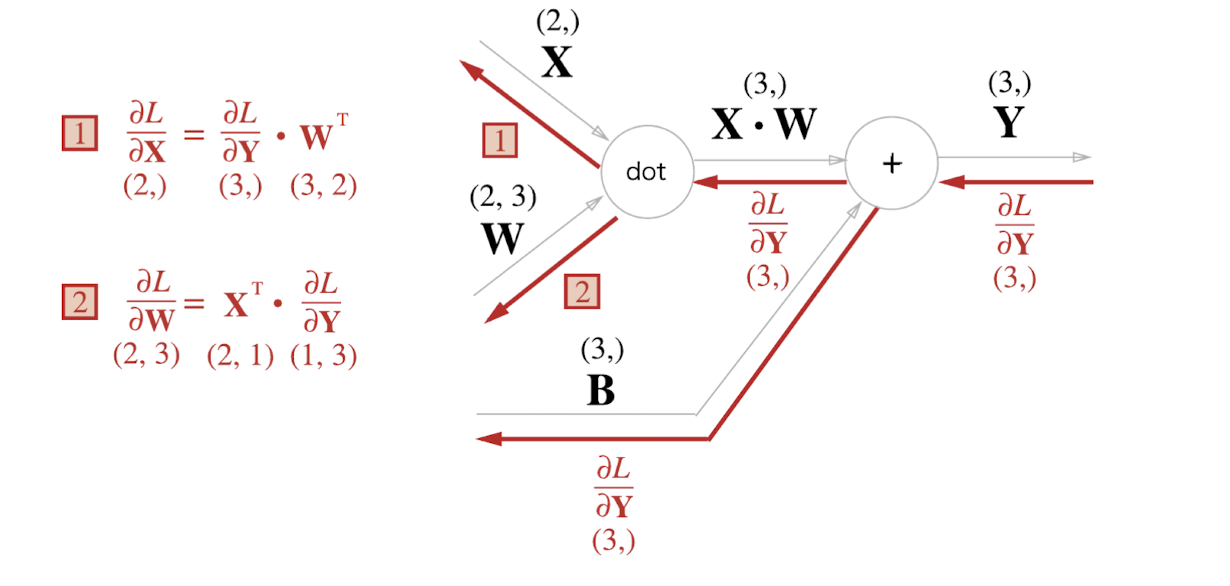

행렬의 형상에 주의해야 한다. 행렬의 곱에서는 대응하는 차원의 원소 수를 일치시켜야 하는데, 이를 위해서는 전치행렬을 동원해야 할 수도 있기 때문이다. (i,j를 j,i)

### 5.6.2 배치용 Affine 계층

지금까지의 Affine 계층은 입력 데이터로 $X$ 하나만을 고려한 것이다. 이번 절에서는 데이터 N개를 묶어(배치) 순전파하는 경우, 즉 배치용 Affine 계층을 생각해 보자.

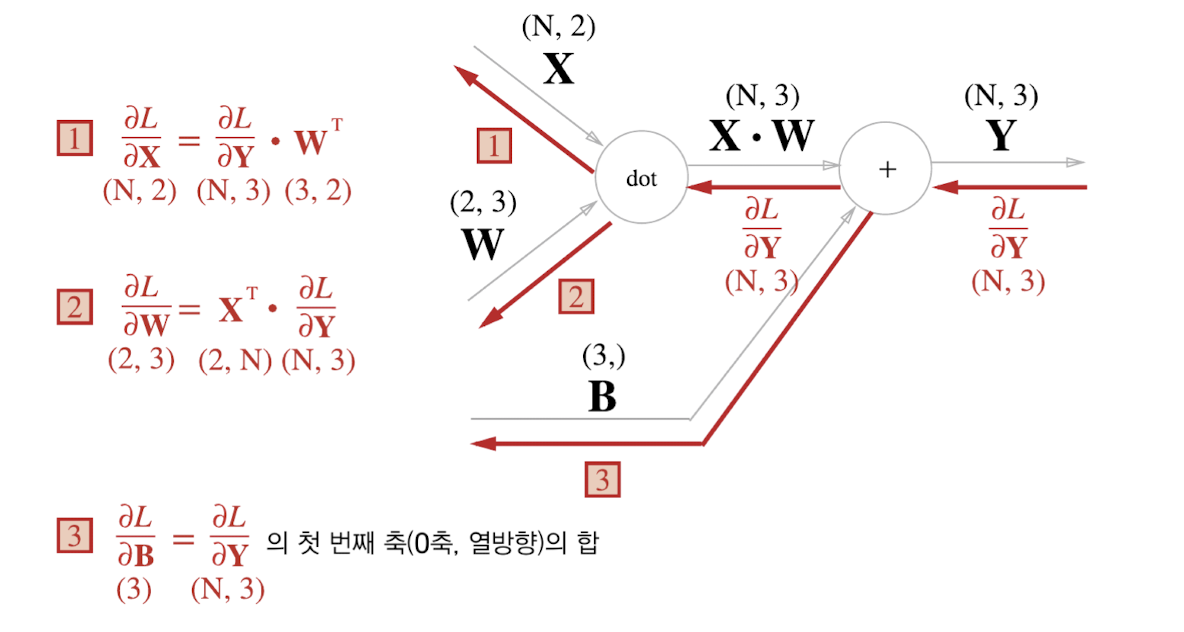

-  기존과 다른 부분은 입력인 $X$의 형상이 (N, 2)가 된 것뿐
- 편향을 더할 때도, 순전파 때의 편향 덧셈은 $X\cdot W$에 대한 편향이 각 데이터에 더해져야 함

In [10]:
X_dot_W = np.array([[0,0,0], [10,10,10]])
B = np.array([1,2,3])

print(X_dot_W)
print(X_dot_W+B)

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]


순전파의 편향 덧셈은 각각의 데이터에 더해진다. 따라서 역전파 때는 각 데이터의 역전파 값이 편향의 원소에 모여야 한다.

In [11]:
dY = np.array([[1,2,3], [4,5,6]])
print(dY)

dB = np.sum(dY, axis=0)
print(dB)

[[1 2 3]
 [4 5 6]]
[5 7 9]


이 예에서는 데이터가 2개, 즉 N=2라 가정한다. 편향의 역전파는 그 두 데이터에 대한 미분을 데이터마다 더해서 구한다. 그래서 np.sum()에서 0번째 축(데이터를 단위로 한 축)에 대해서 (axis=0)의 총합을 구하는 것이다.

In [12]:
# Affine 구현
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)
    return dx

### 5.6.3 Softmax-with-Loss 계층

소프트맥스 함수는 입력 값을 정규화하여 출력한다. 예를 들어 손글씨 숫자 인식에서의 Softmax 계층의 출력은 다음과 같다.

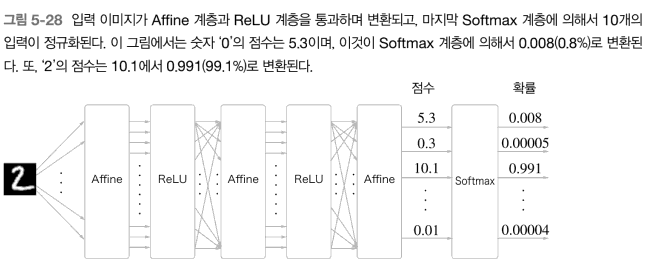

위와 같이 Softmax 계층은 입력 값을 정규화(출력의 합이 1이 되도록 변형)하여 출력한다. 또한, 손글씨 숫자는 가짓수가 10개(10클래스 분류)이므로 Softmax 계층의 입력은 10개가 된다.

신경망에서 수행하는 작업은 학습과 추론 두 가지이다.
- 추론: 추론 시에는 마지막 Affine 계층의 출력을 인식 결과로 이용하며, 신경망에서 정규화하지 않는 출력 결과(Softmax 앞의 Affine 계층의 출력)인 점수(score)를 낼 때, 답을 하나만 내는 경우에는 가장 높은 점수만 알면 되니 Softmax 계층은 필요없다.
- 학습: 학습 시에는 Softmax 계층이 필요하다.

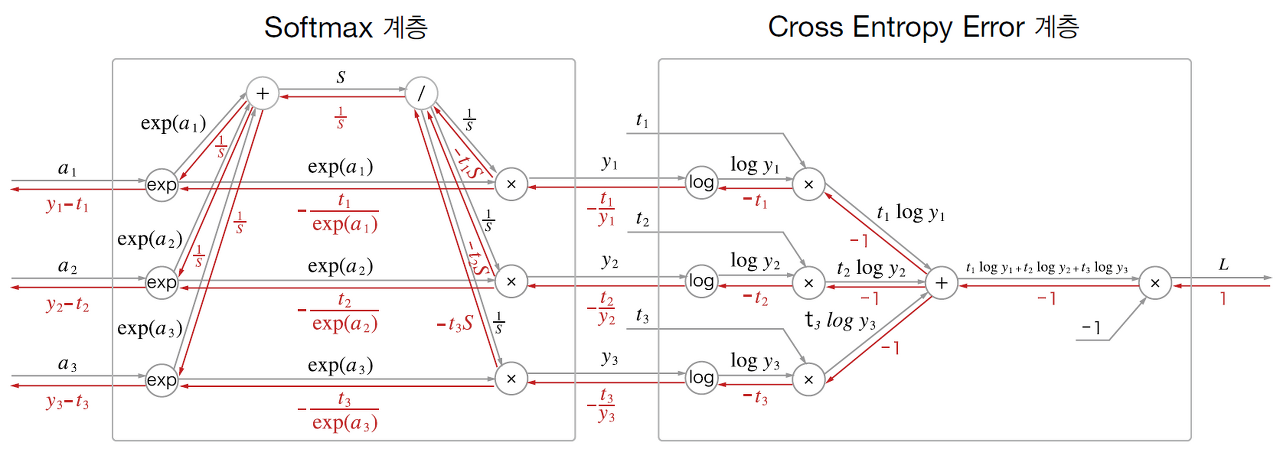

위는 손실 함수인 교차 엔트로피 오차도 포함하여 소프트맥스 계층을 구현한 계산 그래프다. 이는 다음과 같이 간소화할 수 있다.

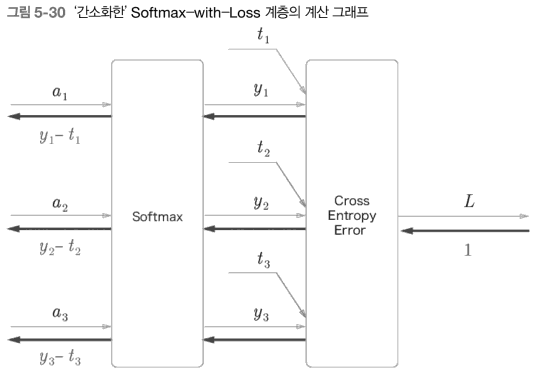

- Softmax 계층: 입력 $(a_1, a_2, a_3)$을 정규화하여 $(y_1, y_2, y_3)$을 출력한다.
- Cross Entropy Error 계층: Softmax의 출력 $(y_1, y_2, y_3)$과 정답 레이블 $(t_1, t_2, t_3)$을 받고, 이 데이터들로부터 손실 $L$ 출력

여기에서 주목할 것은 역전파의 결과인데, Softmax 계층의 역전파는 $(y_1-t_1, y_2-t_2, y_3-t_3)$라는 '말끔한' 결과를 내놓고 있다. 이는 즉, Softmax 계층의 출력과 정답 레이블의 차분을 나타내는데, 이 오차가 신경망의 역전파에서는 앞 계층에 전해지는 것이다.

그런데 신경망 학습의 목적은 신경망의 출력(Softmax의 출력)이 정답 레이블과 가까워지도록 가중치 매개변수의 값을 조정하는 것이었기에 위 오차를 효율적으로 앞 계층에 전달해야 한다. 오차가 작을수록 학습하는 정도도 작아진다.

또한, 역전파 때는 전파하는 값을 배치의 수(batch_size)로 나눠서 데이터 1개당 오차를 앞 계층으로 전파한다. (아래의 코드)



In [ ]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size
    return dx

## 5.7 오차역전파법 구현하기

### 5.7.1 신경망 학습의 전체 그림

<전체>

신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 한다. 신경망 학습은 다음과 같이 4단계로 수행한다.

<1단계 - 미니배치>

- 훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라 하며, 그 미니배치의 손실 함수 값을 줄이는 것이 목표다.

<2단계 - 기울기 산출>

- 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다. 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다.

<3단계 - 매개변수 갱신>

- 가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.

<4단계 - 반복>

- 1~3단계를 반복한다.

### 5.7.2 오차역전파법을 적용한 신경망 구현하기

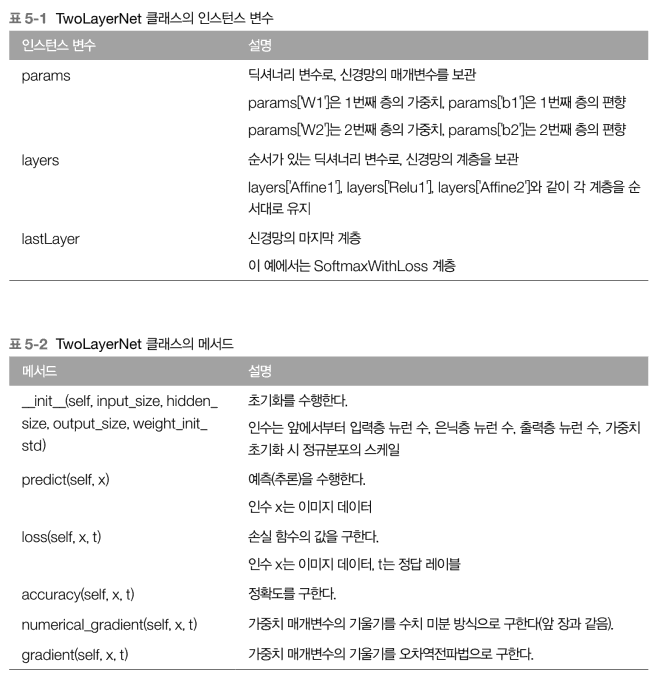

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:

  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    # 가중치 초기화
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    # 계층 생성
    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

    self.lastLayer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  # x: 입력 데이터, t: 정답 레이블
  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1 : t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  # x: 입력 데이터, t: 정답 레이블
  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

    return grads

  def gradient(self, x, t):
    # 순전파
    self.loss(x, t)

    # 역전파
    dout = 1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    # 결과 저장
    grads = {}
    grads['W1'] = self.layers['Affine1'].dW
    grads['b1'] = self.layers['Affine1'].db
    grads['W2'] = self.layers['Affine2'].dW
    grads['b2'] = self.layers['Affine2'].db

    return grads

### 5.7.3 오차역전파법으로 구한 기울기 검증하기

지금까지 기울기를 구하는 방법을 두 가지 설명했다.
- 수치 미분
- 해석적으로 수식을 풀어 구하기: 오차역전파법을 이용하여 매개변수가 많아도 효율적으로 계산 가능

수치 미분은 느리며, 오차역전파법을 제대로 구현하면 수치 미분은 더는 필요가 없을 것이다. 하지만 사실 수치 미분은 오차역전파법을 정확히 구현했는지 확인하기 위해 필요하다. 수치 미분의 이점은 구현하기 쉽다는 점이기에 구현하기 복잡한 오류역전파법의 결과와 비교하여 검증하곤 한다.

이처럼 두 방식으로 구한 기울기가 일치함(엄밀히 거의 같음)을 확인한느 작업을 기울기 확인(gradient check)이라 한다. 이는 다음과 같이 구현한다.

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 차이의 절댓값을 구한 후, 그 절댓값들의 평균을 낸다.
for key in grad_numerical.keys():
  diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
  print(key + ":" + str(diff))

위 코드의 결과는 수치 미분과 오차역전파법으로 구한 기울기의 차이를 말하며, 이 오차로 실수 없이 구현했다는 믿음이 커지는 것이다. (오차가 0에 가까울수록 올바르게 구현한 것)

### 5.7.4 오차역전파법을 사용한 학습 구현하기

In [ ]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist
from ch05.two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 오차역전파법으로 기울기를 구한다.
    # grad = network.numerical_gradient(x_batch, t_batch) : 수치미분법
    grad = network.gradient(x_batch, t_batch)

    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

## 5.8 정리

- 계산 그래프를 이용하면 계산 과정을 시각적으로 파악할 수 있다.
- 계산 그래프의 노드는 국소적 계산으로 구성된다. 국소적 계산을 조합해 전체 계산을 구성한다.
- 계산 그래프의 순전파는 통상의 계산을 수행한다. 한편, 계산 그래프의 역전파로는 각 노드의 미분을 구할 수 있다.
- 신경망의 구성 요소를 계층으로 구현하여 기울기를 효율적으로 계산할 수 있다.(오차역전파법)
- 수치 미분과 오차역전파법의 결과를 비교하면 오차역전파법의 구현에 잘못이 없는지 확인할 수 있다.(기울기 확인)